# Libraries

In [ ]:
import json
from network_implementation import *
from openai import OpenAI
import pandas as pd
import ast
import re
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import numpy as np


client = OpenAI(api_key="")

# Initialization

In [163]:
population_size=10

In [164]:
prompt = f"""
Generate {population_size} unique transaction sequences in Python format. Each sequence should use the following structure:

transaction_sequence = [
    Transaction(entity1, entity2, good1, good2, election754=bool),
    ...
]

**Guidelines:**

1. **Use Variable Names from the Network Initialization Code:**
   - Reference entities, assets, and partnerships using the provided variable names (e.g., `mr_jones`, `jones_co`, `hotel`, `promissory1_mrjones`, `partnership1`, etc.).

2. **Structure of Transactions:**
   - Each transaction should follow this format:
     Transaction(entity1, entity2, good1, good2, election754=bool)
   - `entity1` trades `good1` to `entity2` in exchange for `good2`.
   - Both `entity1` and `entity2` must:
     - Be valid entities defined in the network.
     - Own the respective goods (`good1` and `good2`) they are trading at the time of the transaction.
   - Ownership updates must be consistent after each transaction. For instance, if an entity sells the hotel, they will no longer own the hotel and so, they can no longer sell it in later transactions.  

3. **Ownership Rules and Initial Setup:**
   - Initial ownership in the network:
     - `new_co` owns the `hotel` as an asset.
     - Each entity owns **three promissory notes** as assets (e.g., `promissory1_mrjones`, `promissory2_mrjones`).
     - Each entity has **1,000,000 in cash**.
     - **Partnership relationships**:
       - `mr_jones` has a 99% partnership in `jones_co`.
       - `mr_jones` has a 99% partnership in `family_trust`.
       - `jones_co` has a 99% partnership in `new_co`.

4. **Trading Rules:**
   - `good1` and `good2` can be:
     - **Assets**: For example, promissory notes or the hotel.
     - **Partnerships**: For example, `partnership1`, `partnership2`.
     - **Cash**: Represented as an integer value (e.g., `50000`).
   - **Limit on Cash Transactions:**
     - The cash value being traded cannot exceed the entity's current cash balance, which starts at 1,000,000.

5. **Flexibility and Constraints:**
   - You may:
     - Freely choose valid entities and goods (following ownership rules).
     - Freely choose a boolean for `election754`
     - Specify any numeric values for cash, if cash is traded, within the cash limit.
     - Decide the number of transactions in the `transaction_sequence` (within reason).
     - Arrange the transactions in any logical order.

6. **Requirement:**
   - At least one transaction in each sequence must result in `mr_brown` acquiring ownership of the `hotel`.

**Reference Network Initialization:**

# Create the network
network = Network()

# Create entities
mr_jones = network.add_entity("Mr. Jones", 1000000)
jones_co = network.add_entity("JonesCo", 1000000)
new_co = network.add_entity("NewCo", 1000000)
family_trust = network.add_entity("FamilyTrust", 1000000)
mr_brown = network.add_entity("Mr. Brown", 1000000)

# Add assets
hotel = network.add_asset(new_co, "Hotel", "Material", basis=120, fmv=200)
promissory1_mrjones = network.add_asset(mr_jones, "Promissory Note 1 Mr Jones", "Annuity", basis=100)
promissory2_mrjones = network.add_asset(mr_jones, "Promissory Note 2 Mr Jones", "Annuity", basis=200)
promissory3_mrjones = network.add_asset(mr_jones, "Promissory Note 3 Mr Jones", "Annuity", basis=300)

promissory1_jonesco = network.add_asset(jones_co, "Promissory Note 1 Jones Co", "Annuity", basis=100)
promissory2_jonesco = network.add_asset(jones_co, "Promissory Note 2 Jones Co", "Annuity", basis=200)
promissory3_jonesco = network.add_asset(jones_co, "Promissory Note 3 Jones Co", "Annuity", basis=300)

promissory1_newco = network.add_asset(new_co, "Promissory Note 1 New Co", "Annuity", basis=100)
promissory2_newco = network.add_asset(new_co, "Promissory Note 2 New Co", "Annuity", basis=200)
promissory3_newco = network.add_asset(new_co, "Promissory Note 3 New Co", "Annuity", basis=300)

promissory1_familytrust = network.add_asset(family_trust, "Promissory Note 1 Family Trust", "Annuity", basis=100)
promissory2_familytrust = network.add_asset(family_trust, "Promissory Note 2 Family Trust", "Annuity", basis=200)
promissory3_familytrust = network.add_asset(family_trust, "Promissory Note 3 Family Trust", "Annuity", basis=300)

promissory1_mrbrown = network.add_asset(mr_brown, "Promissory Note 1 Mr Brown", "Annuity", basis=100)
promissory2_mrbrown = network.add_asset(mr_brown, "Promissory Note 2 Mr Brown", "Annuity", basis=200)
promissory3_mrbrown = network.add_asset(mr_brown, "Promissory Note 3 Mr Brown", "Annuity", basis=300)

# Add partnerships
partnership1 = network.add_partnership(mr_jones, jones_co, share=0.99)
partnership2 = network.add_partnership(mr_jones, family_trust, share=0.99)
partnership3 = network.add_partnership(jones_co, new_co, share=0.99)
"""

In [165]:
# Function to save GPT-generated transactions to a text file
def get_transactions_and_save_to_file(prompt, output_file):
    try:
        # Call the OpenAI API
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=1,
            response_format={"type": "text"},  # Expect Python code as text
            messages=[
                {
                    "role": "system",
                    "content": "You are an expert Python developer tasked with generating transaction sequences as Python code."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
        )
        # Parse the response content
        transactions = response.choices[0].message.content

        # Write the raw text directly to the output file
        with open(output_file, "w") as file:
            file.write(transactions)

        print(f"Transaction sequences saved to {output_file}")
    except Exception as e:
        print(f"Error in API call: {e}")


# def parse_transaction_file_to_dataframe(file_path, column_name='Transactions'):
#     """
#     Parses a file containing transaction sequences into a DataFrame and processes the transactions column
#     to create lists of Python-formatted transaction strings.

#     Args:
#         file_path (str): Path to the file containing transaction sequences.
#         column_name (str): The name of the column to store parsed transactions.

#     Returns:
#         pd.DataFrame: A DataFrame containing the parsed transaction sequences and their names.
#     """
#     # Step 1: Extract transaction sequences from the file
#     sequences = []
#     sequence_pattern = r"(transaction_sequence_\d+)\s*=\s*\[(.*?)\]"  # Regex to extract transaction sequences

#     with open(file_path, "r") as file:
#         content = file.read()
#         print('content here', content)
#         matches = re.findall(sequence_pattern, content, re.DOTALL)  # Match all sequences
#         print('matches', matches)
#         for sequence_name, transactions in matches:
#             # Remove newline characters and extra spaces
#             transactions_cleaned = f"[{transactions.strip().replace('\n', '').replace('  ', '')}]"
#             sequences.append({"Sequence_Name": sequence_name, column_name: transactions_cleaned})
#             print('sequences', sequences)

#     # Create a DataFrame
#     transactions_df = pd.DataFrame(sequences)
#     print(transactions_df.head())

#     # Step 2: Parse the Transactions column into Python-formatted transaction strings
#     parsed_transactions = []
#     for trans_seq in transactions_df[column_name]:
#         # Remove leading/trailing whitespace
#         cleaned_trans_seq = trans_seq.strip()

#         # Fix trailing commas in the list
#         if cleaned_trans_seq.endswith(",]"):
#             cleaned_trans_seq = cleaned_trans_seq[:-2] + "]"

#         # Use regex to extract individual transactions
#         transaction_pattern = r"Transaction\((.*?)\)"
#         transactions = re.findall(transaction_pattern, cleaned_trans_seq)

#         # Reconstruct each transaction as a string in Python syntax
#         transaction_list = [f"Transaction({t.strip()})" for t in transactions]
#         parsed_transactions.append(transaction_list)

#     # Update the column with the parsed lists
#     transactions_df[column_name] = parsed_transactions

#     return transactions_df

def parse_transaction_file_to_dataframe(file_path):
    """
    Parses a file containing GPT-generated transaction sequences into a DataFrame.

    Args:
        file_path (str): Path to the file containing transaction sequences.

    Returns:
        pd.DataFrame: DataFrame containing parsed transaction sequences.
    """
    sequences = []
    transaction_pattern = r"Transaction\((.*?)\)"  # Match any `Transaction(...)` pattern

    with open(file_path, "r") as file:
        content = file.read()

        # Split the content into blocks to handle unlabeled sequences
        blocks = re.split(r"transaction_sequence_\d+\s*=\s*\[|\]\s*", content)

        for i, block in enumerate(blocks):
            if block.strip():  # Ignore empty blocks
                # Extract all transactions in the current block
                transactions = re.findall(transaction_pattern, block)
                if transactions:
                    transaction_list = [f"Transaction({t.strip()})" for t in transactions]
                    sequences.append({"Sequence_Name": f"transaction_sequence_{i+1}", "Transactions": transaction_list})

    # Create a DataFrame from parsed sequences
    if not sequences:
        raise ValueError("No valid transaction sequences found in the file. Check the GPT output format.")

    return pd.DataFrame(sequences)



In [154]:
# Function to convert a string to a Transaction object
def string_to_transaction(transaction_string, variables):
    try:
        # Use eval to parse the string with the variables in scope
        transaction = eval(transaction_string, {"Transaction": Transaction}, variables)
        return transaction
    except Exception as e:
        print(f"Error converting string to Transaction: {e}")
        return None

In [166]:
output_file = "transaction_results.txt"  # Use .txt to avoid confusion

# Save GPT-generated transactions to file
get_transactions_and_save_to_file(prompt, output_file)

# Parse the file and create a DataFrame
transactions_df = parse_transaction_file_to_dataframe(output_file)

Transaction sequences saved to transaction_results.txt


In [167]:
transactions_df.head(10)

,Sequence_Name,Transactions
0,transaction_sequence_2,"[Transaction(mr_jones, mr_brown, promissory1_mrjones, 100000, election754=True), Transaction(mr_brown, new_co, 100000, hotel, election754=False)]"
1,transaction_sequence_4,"[Transaction(jones_co, mr_brown, promissory2_jonesco, 200000, election754=True), Transaction(mr_brown, new_co, 200000, hotel, election754=False)]"
2,transaction_sequence_6,"[Transaction(mr_jones, jones_co, promissory3_mrjones, 300000, election754=True), Transaction(jones_co, mr_brown, hotel, 50000, election754=False)]"
3,transaction_sequence_8,"[Transaction(new_co, mr_brown, promissory1_newco, 100000, election754=False), Transaction(mr_jones, mr_brown, hotel, promissory2_mrjones, election754=True)]"
4,transaction_sequence_10,"[Transaction(mr_jones, family_trust, promissory1_mrjones, 150000, election754=True), Transaction(family_trust, mr_brown, hotel, 100000, election754=False)]"
5,transaction_sequence_12,"[Transaction(mr_brown, jones_co, 300000, promissory2_mrbrown, election754=True), Transaction(jones_co, mr_brown, hotel, promissory1_jonesco, election754=False)]"
6,transaction_sequence_14,"[Transaction(jones_co, family_trust, promissory1_jonesco, 100000, election754=True), Transaction(family_trust, mr_brown, hotel, 120000, election754=False)]"
7,transaction_sequence_16,"[Transaction(mr_jones, mr_brown, promissory2_mrjones, 200000, election754=True), Transaction(mr_brown, new_co, 200000, hotel, election754=False)]"
8,transaction_sequence_18,"[Transaction(family_trust, mr_jones, promissory3_familytrust, 300000, election754=False), Transaction(mr_jones, mr_brown, hotel, promissory1_mrjones, election754=True)]"
9,transaction_sequence_20,"[Transaction(mr_brown, new_co, 400000, promissory2_mrbrown, election754=True), Transaction(new_co, mr_brown, hotel, 150000, election754=False)]"


In [168]:
def process_transaction_sequences(transactions_df, generation, results_df=None):
    """
    Processes transaction sequences for a given generation, calculates results, and appends them to the results DataFrame.

    Args:
        transactions_df (pd.DataFrame): The DataFrame containing transaction sequences.
        generation (int): The current generation number.
        results_df (pd.DataFrame): The DataFrame to append results to. If None, a new DataFrame is initialized.

    Returns:
        pd.DataFrame: The updated results DataFrame with appended columns for the current generation.
    """
    # Initialize results_df if not provided
    if results_df is None:
        results_df = pd.DataFrame()

    # Define column names dynamically
    transactions_col = f"Transactions_Gen{generation}"
    results_col = f"Results_Gen{generation}"

    # Initialize lists to store the new generation's transactions and results
    new_transactions = []
    new_results = []

    # Iterate through each transaction sequence
    for tran_seq in transactions_df['Transactions']:
        try:
            # Reinitialize the network
            network = Network()

            # Run the network initialization
            mr_jones = network.add_entity("Mr. Jones", 1000000)
            jones_co = network.add_entity("JonesCo", 1000000)
            new_co = network.add_entity("NewCo", 1000000)
            family_trust = network.add_entity("FamilyTrust", 1000000)
            mr_brown = network.add_entity("Mr. Brown", 1000000)

            hotel = network.add_asset(new_co, "Hotel", "Material", basis=120, fmv=200)
            promissory1_mrjones = network.add_asset(mr_jones, "Promissory Note 1 Mr Jones", "Annuity", basis=100)
            promissory2_mrjones = network.add_asset(mr_jones, "Promissory Note 2 Mr Jones", "Annuity", basis=200)
            promissory3_mrjones = network.add_asset(mr_jones, "Promissory Note 3 Mr Jones", "Annuity", basis=300)

            promissory1_jonesco = network.add_asset(jones_co, "Promissory Note 1 Jones Co", "Annuity", basis=100)
            promissory2_jonesco = network.add_asset(jones_co, "Promissory Note 2 Jones Co", "Annuity", basis=200)
            promissory3_jonesco = network.add_asset(jones_co, "Promissory Note 3 Jones Co", "Annuity", basis=300)

            promissory1_newco = network.add_asset(new_co, "Promissory Note 1 New Co", "Annuity", basis=100)
            promissory2_newco = network.add_asset(new_co, "Promissory Note 2 New Co", "Annuity", basis=200)
            promissory3_newco = network.add_asset(new_co, "Promissory Note 3 New Co", "Annuity", basis=300)

            promissory1_familytrust = network.add_asset(family_trust, "Promissory Note 1 Family Trust", "Annuity", basis=100)
            promissory2_familytrust = network.add_asset(family_trust, "Promissory Note 2 Family Trust", "Annuity", basis=200)
            promissory3_familytrust = network.add_asset(family_trust, "Promissory Note 3 Family Trust", "Annuity", basis=300)

            promissory1_mrbrown = network.add_asset(mr_brown, "Promissory Note 1 Mr Brown", "Annuity", basis=100)
            promissory2_mrbrown = network.add_asset(mr_brown, "Promissory Note 2 Mr Brown", "Annuity", basis=200)
            promissory3_mrbrown = network.add_asset(mr_brown, "Promissory Note 3 Mr Brown", "Annuity", basis=300)

            partnership1 = network.add_partnership(mr_jones, jones_co, share=0.99)
            partnership2 = network.add_partnership(mr_jones, family_trust, share=0.99)
            partnership3 = network.add_partnership(jones_co, new_co, share=0.99)

            variables = {
                "mr_jones": mr_jones,
                "jones_co": jones_co,
                "new_co": new_co,
                "family_trust": family_trust,
                "mr_brown": mr_brown,
                "hotel": hotel,
                "promissory1_mrjones": promissory1_mrjones,
                "promissory2_mrjones": promissory2_mrjones,
                "promissory3_mrjones": promissory3_mrjones,
                "promissory1_jonesco": promissory1_jonesco,
                "promissory2_jonesco": promissory2_jonesco,
                "promissory3_jonesco": promissory3_jonesco,
                "promissory1_newco": promissory1_newco,
                "promissory2_newco": promissory2_newco,
                "promissory3_newco": promissory3_newco,
                "promissory1_familytrust": promissory1_familytrust,
                "promissory2_familytrust": promissory2_familytrust,
                "promissory3_familytrust": promissory3_familytrust,
                "promissory1_mrbrown": promissory1_mrbrown,
                "promissory2_mrbrown": promissory2_mrbrown,
                "promissory3_mrbrown": promissory3_mrbrown,
                "partnership1": partnership1,
                "partnership2": partnership2,
                "partnership3": partnership3,
            }

            # Process all transactions in the sequence
            for trans in tran_seq:
                transaction = string_to_transaction(trans, variables)
                network.process_transaction(transaction)

            # Store the transaction sequence and the fitness result
            new_transactions.append(tran_seq)
            new_results.append(f"Fitness: {network.fitness()}" if hotel in mr_brown.direct_assets else "Error: Mr. Brown does not own the hotel")

        except Exception as e:
            # Store the transaction sequence and the error
            new_transactions.append(tran_seq)
            new_results.append(f"Error: {e}")

    # Append the new columns to the results DataFrame
    results_df[f"Transactions_Gen{generation}"] = new_transactions
    results_df[f"Results_Gen{generation}"] = new_results
    return results_df


In [169]:
results_df = process_transaction_sequences(transactions_df, generation=1)


In [170]:
results_df.head(10)

,Transactions_Gen1,Results_Gen1
0,"[Transaction(mr_jones, mr_brown, promissory1_mrjones, 100000, election754=True), Transaction(mr_brown, new_co, 100000, hotel, election754=False)]",Fitness: 4999920.0
1,"[Transaction(jones_co, mr_brown, promissory2_jonesco, 200000, election754=True), Transaction(mr_brown, new_co, 200000, hotel, election754=False)]",Fitness: 4999920.0
2,"[Transaction(mr_jones, jones_co, promissory3_mrjones, 300000, election754=True), Transaction(jones_co, mr_brown, hotel, 50000, election754=False)]","Error: JonesCo does not own asset Asset(Hotel, type=Material, basis=120, fmv=200)."
3,"[Transaction(new_co, mr_brown, promissory1_newco, 100000, election754=False), Transaction(mr_jones, mr_brown, hotel, promissory2_mrjones, election754=True)]","Error: Mr. Jones does not own asset Asset(Hotel, type=Material, basis=120, fmv=200)."
4,"[Transaction(mr_jones, family_trust, promissory1_mrjones, 150000, election754=True), Transaction(family_trust, mr_brown, hotel, 100000, election754=False)]","Error: FamilyTrust does not own asset Asset(Hotel, type=Material, basis=120, fmv=200)."
5,"[Transaction(mr_brown, jones_co, 300000, promissory2_mrbrown, election754=True), Transaction(jones_co, mr_brown, hotel, promissory1_jonesco, election754=False)]","Error: JonesCo does not own asset Asset(Promissory Note 2 Mr Brown, type=Annuity, basis=200, fmv=200)."
6,"[Transaction(jones_co, family_trust, promissory1_jonesco, 100000, election754=True), Transaction(family_trust, mr_brown, hotel, 120000, election754=False)]","Error: FamilyTrust does not own asset Asset(Hotel, type=Material, basis=120, fmv=200)."
7,"[Transaction(mr_jones, mr_brown, promissory2_mrjones, 200000, election754=True), Transaction(mr_brown, new_co, 200000, hotel, election754=False)]",Fitness: 4999920.0
8,"[Transaction(family_trust, mr_jones, promissory3_familytrust, 300000, election754=False), Transaction(mr_jones, mr_brown, hotel, promissory1_mrjones, election754=True)]","Error: Mr. Jones does not own asset Asset(Hotel, type=Material, basis=120, fmv=200)."
9,"[Transaction(mr_brown, new_co, 400000, promissory2_mrbrown, election754=True), Transaction(new_co, mr_brown, hotel, 150000, election754=False)]","Error: NewCo does not own asset Asset(Promissory Note 2 Mr Brown, type=Annuity, basis=200, fmv=200)."


# Next Generations

In [171]:
num_gen=5

In [172]:
def generate_prompt_for_generation(results_df, generation):
    """
    Generates a GPT prompt for the specified generation using transaction and result columns.

    Args:
        results_df (pd.DataFrame): The DataFrame containing all transaction sequences and results.
        generation (int): The current generation number.

    Returns:
        str: A GPT prompt tailored to the specified generation.
    """
    # Get the relevant columns for the current generation
    transactions_col = f"Transactions_Gen{generation}"
    results_col = f"Results_Gen{generation}"

    # Ensure the required columns exist
    if transactions_col not in results_df.columns or results_col not in results_df.columns:
        raise ValueError(f"Required columns '{transactions_col}' and '{results_col}' not found in DataFrame.")

    # Filter the DataFrame to include only the relevant columns for the current generation
    filtered_df = results_df[[transactions_col, results_col]]

    # Convert the filtered DataFrame to a string
    df_string = filtered_df.to_string(index=False)


    # Create the prompt
    prompt = f"""
    Generate {population_size} new unique transaction sequences to maximize network fitness, given a summary of previously proposed transactions and their results: 

    {df_string}

    Each suggested sequence should use the following structure:

    transaction_sequence = [
        Transaction(entity1, entity2, good1, good2, election754=bool),
        ...
    ]

    **Objective:**
    - Use the previously successful transactions as a foundation and modify them to maximize the network's fitness.
    - If all transactions in a sequence failed, learn from their errors and create new sequences that do not generate errors.

    **Guidelines:**

    1. **Use Variable Names from the Network Initialization Code:**
    - Reference entities, assets, and partnerships using the provided variable names (e.g., `mr_jones`, `jones_co`, `hotel`, `promissory1_mrjones`, `partnership1`, etc.).

    2. **Structure of Transactions:**
    - Each transaction should follow this format:
        Transaction(entity1, entity2, good1, good2, election754=bool)
    - `entity1` trades `good1` to `entity2` in exchange for `good2`.
    - Both `entity1` and `entity2` must:
        - Be valid entities defined in the network.
        - Own the respective goods (`good1` and `good2`) they are trading at the time of the transaction.
    - Ownership updates must be consistent after each transaction. For instance, if an entity sells the hotel, they will no longer own the hotel and so, they can no longer sell it in later transactions.  

    3. **Ownership Rules and Initial Setup:**
    - Initial ownership in the network:
        - `new_co` owns the `hotel` as an asset.
        - Each entity owns **three promissory notes** as assets (e.g., `promissory1_mrjones`, `promissory2_mrjones`).
        - Each entity has **1,000,000 in cash**.
        - **Partnership relationships**:
        - `mr_jones` has a 99% partnership in `jones_co`.
        - `mr_jones` has a 99% partnership in `family_trust`.
        - `jones_co` has a 99% partnership in `new_co`.

    4. **Trading Rules:**
    - `good1` and `good2` can be:
        - **Assets**: For example, promissory notes or the hotel.
        - **Partnerships**: For example, `partnership1`, `partnership2`.
        - **Cash**: Represented as an integer value (e.g., `50000`).
    - **Limit on Cash Transactions:**
        - The cash value being traded cannot exceed the entity's current cash balance, which starts at 1,000,000.

    5. **Flexibility and Constraints:**
    - You may:
        - Freely choose valid entities and goods (following ownership rules).
        - Freely choose a boolean for `election754`:
        - Set `election754=True` only if at least one of the goods being traded is a partnership.
        - Specify any numeric values for cash, if cash is traded, within the cash limit.
        - Decide the number of transactions in the `transaction_sequence` (within reason).
        - Arrange the transactions in any logical order.

    6. **Optimization Strategies:**
    - Refine Successful Transactions:
    - Use previously successful transactions as a starting point.
    - Adjust details such as entities, assets, cash values, or the `election754` flag to improve network fitness.
    - Combine Elements:
    - Merge components from different successful sequences to create new, optimized transaction sequences.
    - Introduce Mutations:
    - Mutate sequences by altering specific aspects, such as:
        - Changing traded goods (`good1` or `good2`).
        - Adjusting cash amounts (within allowable limits).
        - Toggling the `election754` flag.
    - Handle Failures:
    - For sequences where all transactions failed:
        - Design entirely new transaction sequences.
        - Ensure these sequences follow all rules and constraints.
        - Aim to avoid errors while maximizing network fitness.


    7. **Requirement:**
    - At least one transaction in each sequence must result in `mr_brown` acquiring ownership of the `hotel`.

    **Reference Network Initialization:**

    # Create the network
    network = Network()

    # Create entities
    mr_jones = network.add_entity("Mr. Jones", 1000000)
    jones_co = network.add_entity("JonesCo", 1000000)
    new_co = network.add_entity("NewCo", 1000000)
    family_trust = network.add_entity("FamilyTrust", 1000000)
    mr_brown = network.add_entity("Mr. Brown", 1000000)

    # Add assets
    hotel = network.add_asset(new_co, "Hotel", "Material", basis=120, fmv=200)
    promissory1_mrjones = network.add_asset(mr_jones, "Promissory Note 1 Mr Jones", "Annuity", basis=100)
    promissory2_mrjones = network.add_asset(mr_jones, "Promissory Note 2 Mr Jones", "Annuity", basis=200)
    promissory3_mrjones = network.add_asset(mr_jones, "Promissory Note 3 Mr Jones", "Annuity", basis=300)

    promissory1_jonesco = network.add_asset(jones_co, "Promissory Note 1 Jones Co", "Annuity", basis=100)
    promissory2_jonesco = network.add_asset(jones_co, "Promissory Note 2 Jones Co", "Annuity", basis=200)
    promissory3_jonesco = network.add_asset(jones_co, "Promissory Note 3 Jones Co", "Annuity", basis=300)

    promissory1_newco = network.add_asset(new_co, "Promissory Note 1 New Co", "Annuity", basis=100)
    promissory2_newco = network.add_asset(new_co, "Promissory Note 2 New Co", "Annuity", basis=200)
    promissory3_newco = network.add_asset(new_co, "Promissory Note 3 New Co", "Annuity", basis=300)

    promissory1_familytrust = network.add_asset(family_trust, "Promissory Note 1 Family Trust", "Annuity", basis=100)
    promissory2_familytrust = network.add_asset(family_trust, "Promissory Note 2 Family Trust", "Annuity", basis=200)
    promissory3_familytrust = network.add_asset(family_trust, "Promissory Note 3 Family Trust", "Annuity", basis=300)

    promissory1_mrbrown = network.add_asset(mr_brown, "Promissory Note 1 Mr Brown", "Annuity", basis=100)
    promissory2_mrbrown = network.add_asset(mr_brown, "Promissory Note 2 Mr Brown", "Annuity", basis=200)
    promissory3_mrbrown = network.add_asset(mr_brown, "Promissory Note 3 Mr Brown", "Annuity", basis=300)

    # Add partnerships
    partnership1 = network.add_partnership(mr_jones, jones_co, share=0.99)
    partnership2 = network.add_partnership(mr_jones, family_trust, share=0.99)
    partnership3 = network.add_partnership(jones_co, new_co, share=0.99)
    """
        
    return prompt

In [173]:
#Storing a copy of the original results (from first generation)
results_df_copy=results_df.copy()

In [139]:
results_df_copy.head()

,Transactions_Gen1,Results_Gen1
0,"[Transaction(mr_jones, mr_brown, promissory1_mrjones, 50000, election754=False), Transaction(mr_brown, new_co, 50000, hotel, election754=True)]",Fitness: 4999920.0
1,"[Transaction(jones_co, mr_brown, promissory1_jonesco, 100000, election754=False), Transaction(mr_brown, new_co, 100000, hotel, election754=True)]",Fitness: 4999920.0
2,"[Transaction(mr_jones, jones_co, promissory2_mrjones, promissory1_jonesco, election754=False), Transaction(jones_co, mr_brown, hotel, promissory1_jonesco, election754=True)]","Error: JonesCo does not own asset Asset(Hotel, type=Material, basis=120, fmv=200)."
3,"[Transaction(mr_brown, mr_jones, 200000, promissory1_mrbrown, election754=False), Transaction(mr_jones, new_co, promissory1_mrjones, hotel, election754=True)]","Error: Mr. Jones does not own asset Asset(Promissory Note 1 Mr Brown, type=Annuity, basis=100, fmv=100)."
4,"[Transaction(mr_brown, family_trust, 100000, promissory1_mrbrown, election754=False), Transaction(family_trust, new_co, hotel, promissory1_familytrust, election754=True)]","Error: FamilyTrust does not own asset Asset(Promissory Note 1 Mr Brown, type=Annuity, basis=100, fmv=100)."


In [174]:
for i in range(1, num_gen):
    #Get prompt:
    prompt=generate_prompt_for_generation(results_df_copy, i)
    #Get transaction file:
    output_file = "transaction_results.txt"  # Use .txt to avoid confusion
    get_transactions_and_save_to_file(prompt, output_file)

    transactions_df = parse_transaction_file_to_dataframe(output_file)
    #print('PROPOSED TRANSACTIONS: ', transactions_df.head())

    #Update results df
    results_df_copy = process_transaction_sequences(transactions_df, generation=i+1, results_df=results_df_copy)

    

    

Transaction sequences saved to transaction_results.txt
Transaction sequences saved to transaction_results.txt
Transaction sequences saved to transaction_results.txt
Transaction sequences saved to transaction_results.txt


In [175]:
results_df_copy.head(10)

,Transactions_Gen1,Results_Gen1,Transactions_Gen2,Results_Gen2,Transactions_Gen3,Results_Gen3,Transactions_Gen4,Results_Gen4,Transactions_Gen5,Results_Gen5
0,"[Transaction(mr_jones, mr_brown, promissory1_mrjones, 100000, election754=True), Transaction(mr_brown, new_co, 100000, hotel, election754=False)]",Fitness: 4999920.0,"[Transaction(mr_jones, new_co, promissory1_mrjones, 150000, election754=True), Transaction(new_co, mr_brown, hotel, promissory1_newco, election754=False)]","Error: Mr. Brown does not own asset Asset(Promissory Note 1 New Co, type=Annuity, basis=100, fmv=100).","[Transaction(mr_jones, new_co, promissory1_mrjones, 100000, election754=False), Transaction(new_co, mr_brown, hotel, promissory1_newco, election754=True)]","Error: Mr. Brown does not own asset Asset(Promissory Note 1 New Co, type=Annuity, basis=100, fmv=100).","[Transaction(mr_jones, mr_brown, promissory1_mrjones, 100000, election754=False), Transaction(mr_brown, new_co, promissory1_mrbrown, 50000, election754=False), Transaction(new_co, mr_brown, hotel, 20000, election754=False)]",Fitness: 4999920.0,"[Transaction(new_co, mr_brown, hotel, promissory2_newco, election754=False), Transaction(mr_brown, family_trust, promissory1_mrbrown, 200000, election754=False), Transaction(family_trust, jones_co, promissory2_familytrust, 100000, election754=False)]","Error: Mr. Brown does not own asset Asset(Promissory Note 2 New Co, type=Annuity, basis=200, fmv=200)."
1,"[Transaction(jones_co, mr_brown, promissory2_jonesco, 200000, election754=True), Transaction(mr_brown, new_co, 200000, hotel, election754=False)]",Fitness: 4999920.0,"[Transaction(jones_co, mr_brown, promissory2_jonesco, 250000, election754=False), Transaction(mr_brown, new_co, 200000, hotel, election754=False)]",Fitness: 4999920.0,"[Transaction(jones_co, mr_brown, promissory2_jonesco, 200000, election754=False), Transaction(mr_brown, new_co, hotel, promissory1_newco, election754=True), Transaction(new_co, mr_jones, 50000, promissory1_newco, election754=False)]","Error: Mr. Brown does not own asset Asset(Hotel, type=Material, basis=120, fmv=200).","[Transaction(family_trust, mr_brown, promissory1_familytrust, 120000, election754=False), Transaction(mr_brown, new_co, promissory2_mrbrown, 100000, election754=False), Transaction(new_co, mr_brown, hotel, 80000, election754=False)]",Fitness: 4999920.0,"[Transaction(mr_jones, new_co, promissory1_mrjones, 70000, election754=False), Transaction(new_co, mr_brown, hotel, 200000, election754=False), Transaction(mr_brown, jones_co, promissory2_mrbrown, 100000, election754=False)]",Fitness: 4999920.0
2,"[Transaction(mr_jones, jones_co, promissory3_mrjones, 300000, election754=True), Transaction(jones_co, mr_brown, hotel, 50000, election754=False)]","Error: JonesCo does not own asset Asset(Hotel, type=Material, basis=120, fmv=200).","[Transaction(family_trust, mr_jones, promissory3_familytrust, 100000, election754=False), Transaction(mr_jones, mr_brown, promissory1_mrjones, 120000, election754=True), Transaction(mr_brown, new_co, 300000, hotel, election754=False)]",Fitness: 4999920.0,"[Transaction(family_trust, new_co, promissory2_familytrust, 150000, election754=False), Transaction(new_co, mr_brown, hotel, 80000, election754=False), Transaction(mr_brown, jones_co, promissory1_mrbrown, 100000, election754=False)]",Fitness: 4999920.0,"[Transaction(mr_brown, jones_co, promissory2_mrbrown, 100000, election754=False), Transaction(jones_co, new_co, promissory1_jonesco, 200000, election754=False), Transaction(new_co, mr_brown, hotel, 30000, election754=False)]",Fitness: 4999920.0,"[Transaction(mr_jones, family_trust, promissory3_mrjones, 150000, election754=False), Transaction(family_trust, new_co, hotel, 200000, election754=False), Transaction(new_co, mr_brown, promissory1_newco, 50000, election754=False)]","Error: FamilyTrust does not own asset Asset(Hotel, type=Material, basis=120, fmv=200)."
3,"[Transaction(new_co, mr_brown, promissory1_newco, 100000, election754=Fa

# Evaluating Graphs

In [176]:
# Initialize a list to store metrics for each generation
generation_metrics = []

# Iterate through all columns in the DataFrame
for column in results_df_copy.columns:
    if column.startswith("Results_Gen"):
        # Extract the generation number
        generation_number = int(column.split("_")[-1][3:])
        
        # Filter column data
        column_data = results_df_copy[column]
        
        # Count errors
        error_count = column_data.str.startswith("Error").sum()
        
        # Extract fitness values and calculate the average
        fitness_values = column_data[column_data.str.startswith("Fitness")].str.extract(r"Fitness: (\d+\.\d+)")[0].astype(float)
        average_fitness = fitness_values.mean() if not fitness_values.empty else 0

        # Store metrics for this generation
        generation_metrics.append({
            "Generation": generation_number,
            "Error Count": error_count,
            "Average Fitness": average_fitness
        })

# Convert metrics into a DataFrame
metrics_df = pd.DataFrame(generation_metrics)



In [177]:
metrics_df.head()

,Generation,Error Count,Average Fitness
0,1,7,4999920.0
1,2,7,4999920.0
2,3,7,4999920.0
3,4,4,4999920.0
4,5,7,4999920.0


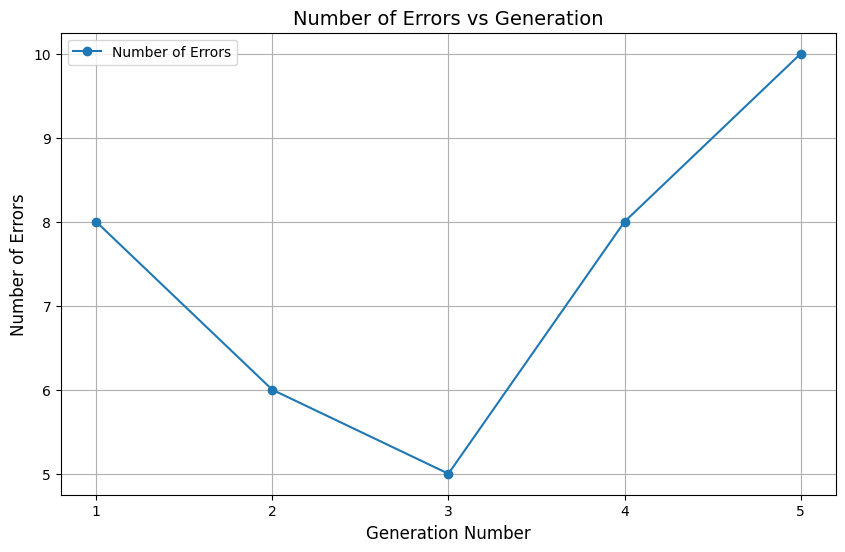

In [ ]:
# Plot Number of Errors vs Generation
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Generation'], metrics_df['Error Count'], marker='o', label='Number of Errors')
plt.title('Number of Errors vs Generation', fontsize=14)
plt.xlabel('Generation Number',
            fontsize=12)
plt.ylabel('Number of Errors', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(1, metrics_df['Generation'].max() + 1, 1))  # Set x-axis ticks to whole numbers
plt.legend()
plt.show()


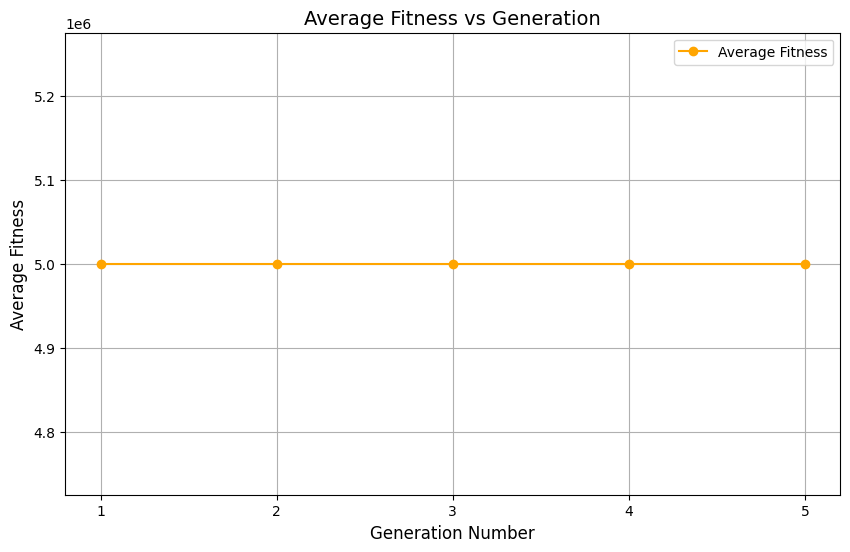

In [178]:
# Plot Average Fitness vs Generation
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Generation'], metrics_df['Average Fitness'], marker='o', color='orange', label='Average Fitness')
plt.title('Average Fitness vs Generation', fontsize=14)
plt.xlabel('Generation Number', fontsize=12)
plt.ylabel('Average Fitness', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(1, metrics_df['Generation'].max() + 1, 1))  # Set x-axis ticks to whole numbers
plt.legend()
plt.show()